In [8]:
import os
import cv2
import numpy as np
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [9]:
DATA_PATH = "/kaggle/input/face-mask-detection"

IMAGE_PATH = os.path.join(DATA_PATH, "images")
ANNOT_PATH = os.path.join(DATA_PATH, "annotations")

print(os.listdir(IMAGE_PATH)[:5])
print(os.listdir(ANNOT_PATH)[:5])

['maksssksksss810.png', 'maksssksksss848.png', 'maksssksksss145.png', 'maksssksksss825.png', 'maksssksksss30.png']
['maksssksksss737.xml', 'maksssksksss410.xml', 'maksssksksss537.xml', 'maksssksksss295.xml', 'maksssksksss771.xml']


In [10]:
def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    boxes = []
    labels = []

    for obj in root.findall("object"):
        label = obj.find("name").text
        bbox = obj.find("bndbox")

        xmin = int(bbox.find("xmin").text)
        ymin = int(bbox.find("ymin").text)
        xmax = int(bbox.find("xmax").text)
        ymax = int(bbox.find("ymax").text)

        boxes.append([xmin, ymin, xmax, ymax])
        labels.append(label)

    return boxes, labels

In [11]:
IMG_SIZE = 224

label_map = {
    "with_mask": 0,
    "without_mask": 1,
    "mask_weared_incorrect": 2
}

images = []
bbox_labels = []
class_labels = []

for img_name in os.listdir(IMAGE_PATH):
    img_path = os.path.join(IMAGE_PATH, img_name)
    xml_path = os.path.join(ANNOT_PATH, img_name.replace(".png", ".xml"))

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    h, w, _ = img.shape

    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0

    boxes, labels = parse_xml(xml_path)

    # assume one face per image
    x1, y1, x2, y2 = boxes[0]
    bbox_labels.append([x1/w, y1/h, x2/w, y2/h])
    class_labels.append(label_map[labels[0]])

    images.append(img)

images = np.array(images)
bbox_labels = np.array(bbox_labels)
class_labels = np.array(class_labels)

print(images.shape, bbox_labels.shape, class_labels.shape)

(853, 224, 224, 3) (853, 4) (853,)


In [12]:
X_train, X_test, y_bbox_train, y_bbox_test, y_class_train, y_class_test = train_test_split(
    images,
    bbox_labels,
    class_labels,
    test_size=0.2,
    random_state=42
)

In [13]:
from tensorflow.keras.applications import MobileNetV2

base_model = MobileNetV2(
    input_shape=(224,224,3),
    include_top=False,
    weights="imagenet"
)

base_model.trainable = False

x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)

bbox_output = tf.keras.layers.Dense(4, activation="sigmoid", name="bbox")(x)
class_output = tf.keras.layers.Dense(3, activation="softmax", name="class")(x)

model = tf.keras.Model(
    inputs=base_model.input,
    outputs=[bbox_output, class_output]
)

In [14]:
model.compile(
    optimizer="adam",
    loss={
        "bbox": "mse",
        "class": "sparse_categorical_crossentropy"
    },
    metrics={"class": "accuracy"}
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,266,951 (8.65 MB)

 Trainable params: 8,967 (35.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [15]:
history = model.fit(
    X_train,
    {
        "bbox": y_bbox_train,
        "class": y_class_train
    },
    validation_split=0.1,
    epochs=10,
    batch_size=32
)

Epoch 1/10


I0000 00:00:1766598656.758439     143 service.cc:148] XLA service 0x7c63b4003ca0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1766598656.759204     143 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1766598657.584474     143 cuda_dnn.cc:529] Loaded cuDNN version 90300


 6/20 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - bbox_loss: 0.0785 - class_accuracy: 0.5583 - class_loss: 0.9453 - loss: 1.0237

I0000 00:00:1766598661.072210     143 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 421ms/step - bbox_loss: 0.0674 - class_accuracy: 0.7106 - class_loss: 0.7927 - loss: 0.8622 - val_bbox_loss: 0.0424 - val_class_accuracy: 0.7681 - val_class_loss: 0.8242 - val_loss: 0.6091
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - bbox_loss: 0.0433 - class_accuracy: 0.8399 - class_loss: 0.5144 - loss: 0.5589 - val_bbox_loss: 0.0373 - val_class_accuracy: 0.8261 - val_class_loss: 0.8176 - val_loss: 0.6160
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - bbox_loss: 0.0326 - class_accuracy: 0.8834 - class_loss: 0.4070 - loss: 0.4366 - val_bbox_loss: 0.0338 - val_class_accuracy: 0.8551 - val_class_loss: 0.7763 - val_loss: 0.5619
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - bbox_loss: 0.0290 - class_accuracy: 0.8958 - class_loss: 0.3438 - loss: 0.3736 - val_bbox_loss: 0.0329 - val_class_accuracy: 0.8406 - val_class_loss: 0.7501 - val_loss: 0.5503
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - bbox_loss: 0.0272 - class_accuracy: 0.89

In [18]:
model.save("/kaggle/working/mask_detector.h5")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


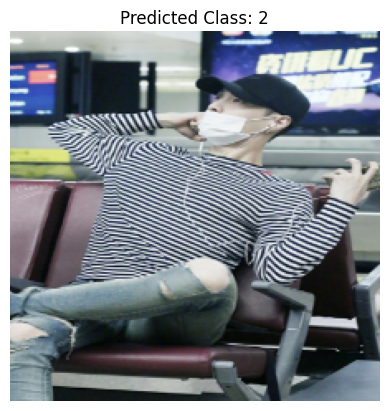

In [19]:
import random
import matplotlib.pyplot as plt
import numpy as np

idx = random.randint(0, len(X_test)-1)
img = X_test[idx]

bbox_pred, class_pred = model.predict(np.expand_dims(img, axis=0))

plt.imshow(img)
plt.axis("off")
plt.title(f"Predicted Class: {np.argmax(class_pred)}")
plt.show()

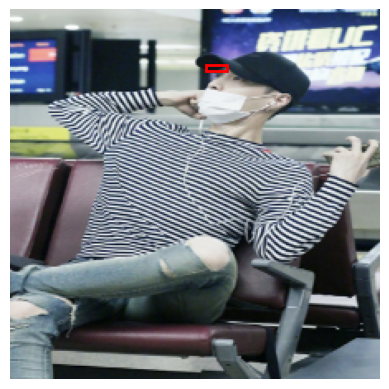

In [20]:
h, w, _ = img.shape
x1, y1, x2, y2 = bbox_pred[0]

x1 = int(x1 * w)
y1 = int(y1 * h)
x2 = int(x2 * w)
y2 = int(y2 * h)

plt.imshow(img)
plt.gca().add_patch(
    plt.Rectangle((x1, y1), x2-x1, y2-y1,
                  fill=False, edgecolor="red", linewidth=2)
)
plt.axis("off")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


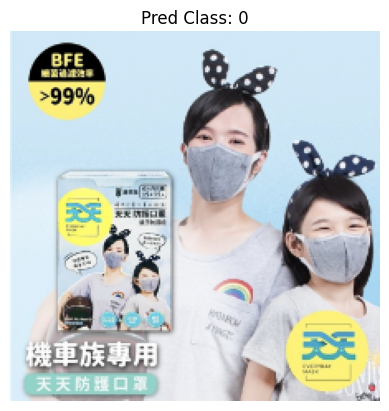

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


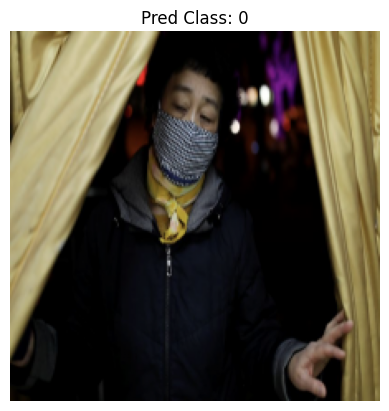

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


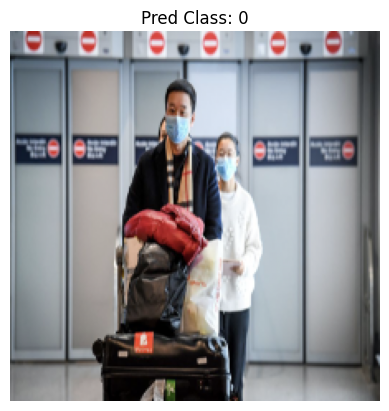

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


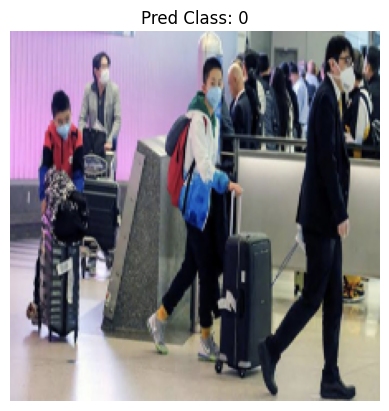

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


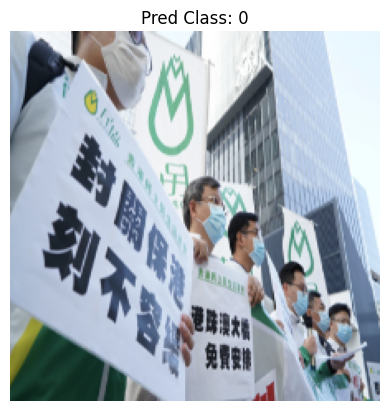

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


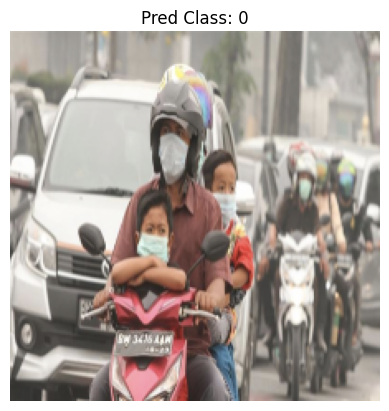

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


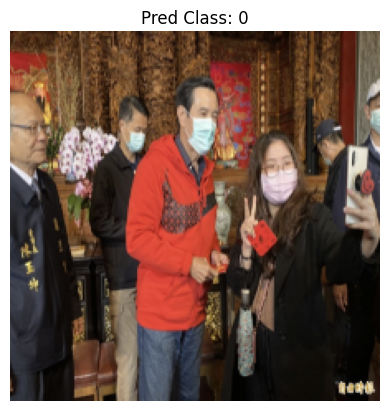

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


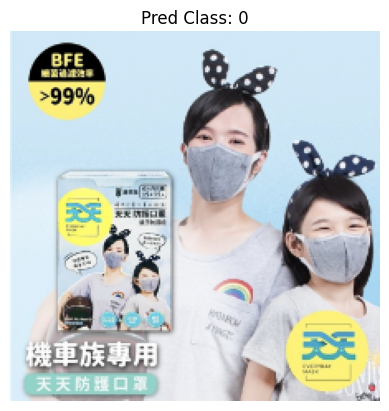

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


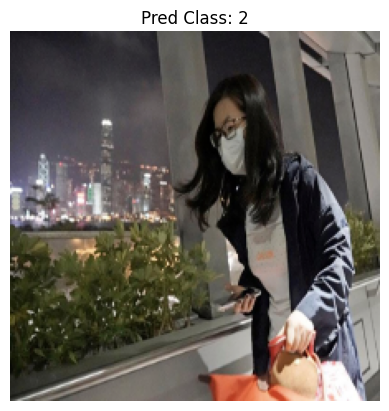

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


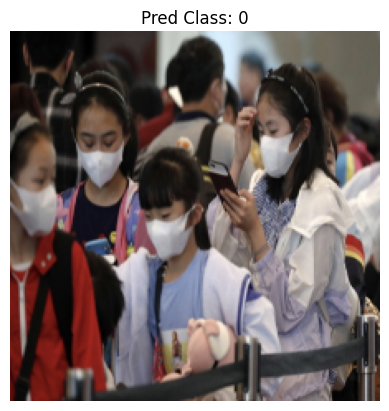

In [21]:
for i in range(10):
    idx = random.randint(0, len(X_test)-1)
    img = X_test[idx]

    bbox_pred, class_pred = model.predict(np.expand_dims(img, axis=0))

    plt.imshow(img)
    plt.title(f"Pred Class: {np.argmax(class_pred)}")
    plt.axis("off")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


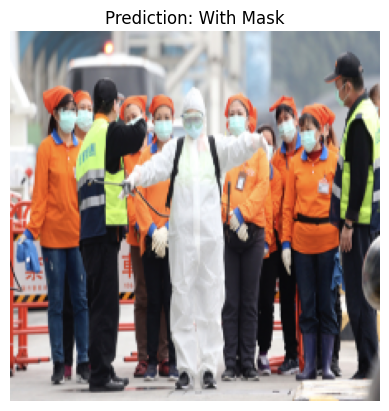

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


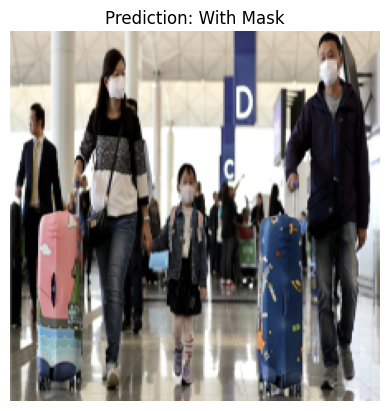

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


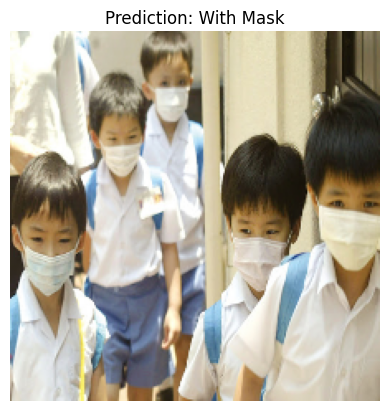

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


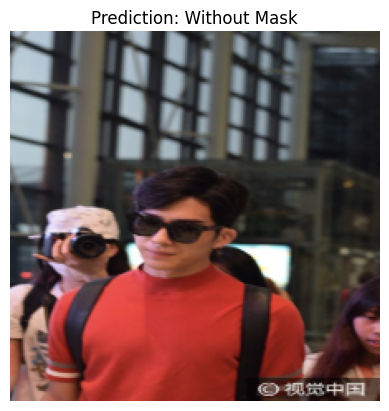

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


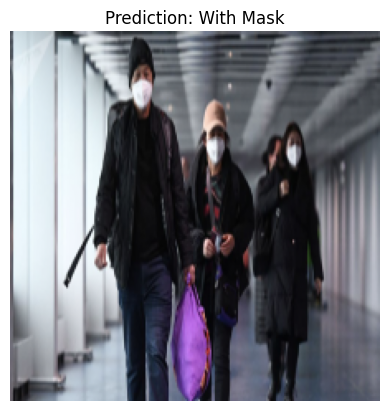

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


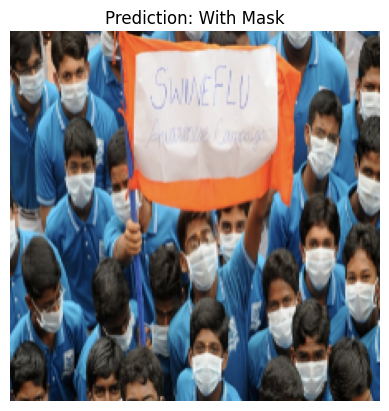

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


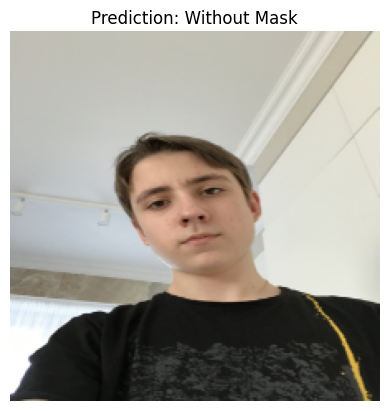

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


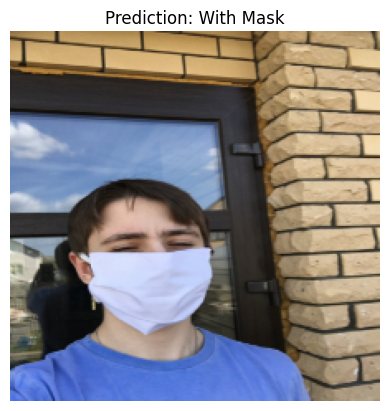

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


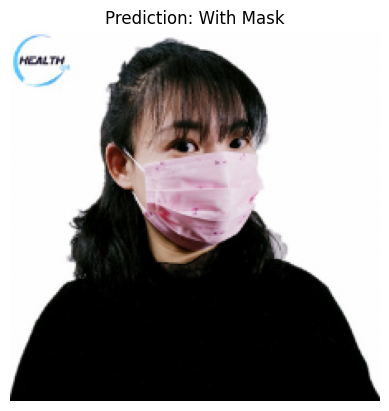

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


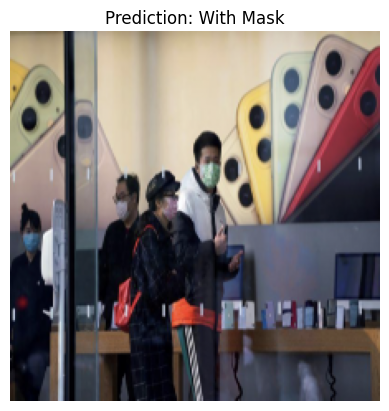

In [22]:
class_names = [
    "With Mask",
    "Without Mask",
    "Mask Worn Incorrectly"
]

for i in range(10):
    idx = random.randint(0, len(X_test)-1)
    img = X_test[idx]

    bbox_pred, class_pred = model.predict(np.expand_dims(img, axis=0))
    pred_class = class_names[np.argmax(class_pred)]

    plt.imshow(img)
    plt.title(f"Prediction: {pred_class}")
    plt.axis("off")
    plt.show()

## IoU @ 0.5 (Intersection over Union)

In [25]:
def compute_iou(boxA, boxB):
    # box format: [x1, y1, x2, y2]

    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    inter_width = max(0, xB - xA)
    inter_height = max(0, yB - yA)
    inter_area = inter_width * inter_height

    boxA_area = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxB_area = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    union_area = boxA_area + boxB_area - inter_area

    if union_area == 0:
        return 0

    return inter_area / union_area


In [26]:
iou_scores = []

for i in range(len(X_test)):
    img = X_test[i]
    true_box = y_bbox_test[i]

    pred_box, _ = model.predict(np.expand_dims(img, axis=0))
    pred_box = pred_box[0]

    iou = compute_iou(true_box, pred_box)
    iou_scores.append(iou)

iou_scores = np.array(iou_scores)

# IoU ≥ 0.5 count
iou_05 = np.sum(iou_scores >= 0.5)

print("Total test samples:", len(iou_scores))
print("IoU >= 0.5:", iou_05)
print("IoU@0.5 Accuracy:", iou_05 / len(iou_scores))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━

In [28]:
y_true = []
y_pred = []

for i in range(len(X_test)):
    _, class_pred = model.predict(np.expand_dims(X_test[i], axis=0))
    y_pred.append(np.argmax(class_pred))
    y_true.append(y_class_test[i])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━

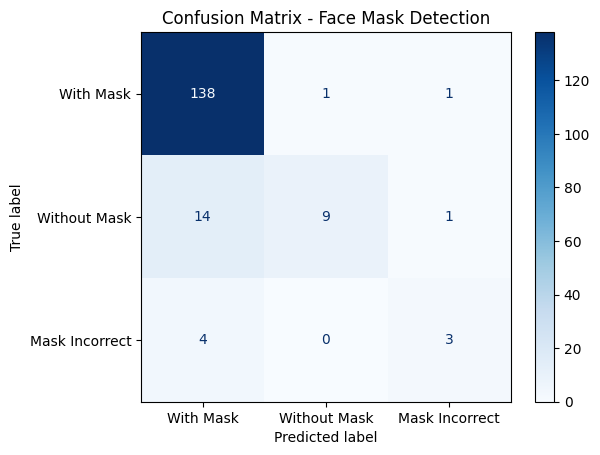

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

class_names = [
    "With Mask",
    "Without Mask",
    "Mask Incorrect"
]

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=class_names
)

disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Face Mask Detection")
plt.show()